# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="whitegrid")

%matplotlib inline

In [2]:
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, StringIndexer,OneHotEncoderEstimator ,VectorAssembler
from pyspark.ml.classification import LogisticRegression, LinearSVC,RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# create a Spark session
spark = SparkSession.builder.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

# Data Overview

In [4]:
events_df = spark.read.json('mini_sparkify_event_data.json')

In [5]:
events_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
events_df.toPandas().iloc[0]

artist                                              Martha Tilston
auth                                                     Logged In
firstName                                                    Colin
gender                                                           M
itemInSession                                                   50
lastName                                                   Freeman
length                                                      277.89
level                                                         paid
location                                           Bakersfield, CA
method                                                         PUT
page                                                      NextSong
registration                                           1.53817e+12
sessionId                                                       29
song                                                     Rockpools
status                                                        

In [7]:
events_df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [8]:
events_df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [9]:
events_df.count()

286500

Let us see the describe method. Generally in databricks you can see the output very clearly using **events_df.describe().show()**. 

Since the display isn't good in jupyter environment, we convert it into pandas here 

In [10]:
events_df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [11]:
events_df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



There is one problem above. **min(userId)** is *\"\"* which means there are records with userId as empty strings. We will have to filter those records out.

In [12]:
events_df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [13]:
events_df.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in events_df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



Seems like there is no null values in any columns. But we have to filter out for the empty strings in the *userId* column.

# Cleaning the data

In [14]:
events_df.where(F.col('userId')=='').count()

8346

In [15]:
events_df = events_df.where( F.col('userId') != '')

In [16]:
events_df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# EDA

In [17]:
events_df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

Let us analyse the distribution of some important columns.

### auth

In [18]:
events_df.select('auth').distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [19]:
events_df.groupby('auth').agg(F.countDistinct('userId')).show()

+---------+----------------------+
|     auth|count(DISTINCT userId)|
+---------+----------------------+
|Cancelled|                    52|
|Logged In|                   225|
+---------+----------------------+



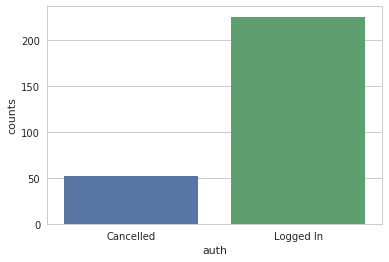

In [20]:
auth_df  = events_df.groupby('auth').agg(F.countDistinct('userId').alias('counts')).toPandas()
sns.barplot(x='auth',y='counts',data=auth_df)

### gender

In [21]:
events_df.groupby('gender').agg(F.countDistinct('userId')).show()

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|     F|                   104|
|     M|                   121|
+------+----------------------+



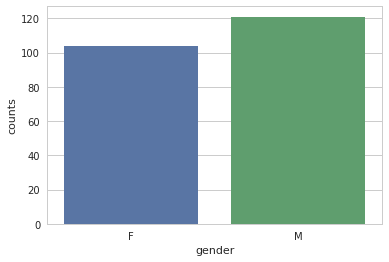

In [22]:
gender_df  = events_df.groupby('gender').agg(F.countDistinct('userId').alias('counts')).toPandas()
sns.barplot(x='gender',y='counts',data=gender_df)

### itemInSession

In [23]:
events_df.select('itemInSession').distinct().count()

1311

### length

In [24]:
lengths =  events_df.select('length').toPandas()['length'].dropna().values

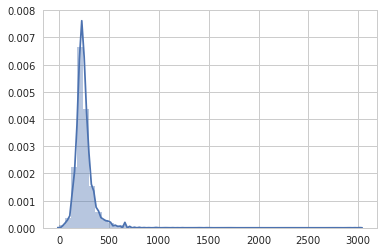

In [25]:
sns.distplot(lengths)

### level

In [26]:
events_df.groupby('level').agg(F.countDistinct('userId')).show()

+-----+----------------------+
|level|count(DISTINCT userId)|
+-----+----------------------+
| free|                   195|
| paid|                   165|
+-----+----------------------+



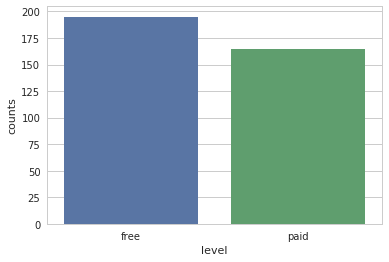

In [27]:
level_df  = events_df.groupby('level').agg(F.countDistinct('userId').alias('counts')).toPandas()
sns.barplot(x='level',y='counts',data=level_df)

### location

In [28]:
events_df.groupby('location').agg(F.countDistinct('userId').alias('count')).sort('count', ascending = False).show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Los Angeles-Long ...|   16|
|New York-Newark-J...|   15|
|Dallas-Fort Worth...|    7|
|Phoenix-Mesa-Scot...|    7|
|    St. Louis, MO-IL|    6|
|Chicago-Napervill...|    6|
|Charlotte-Concord...|    6|
|Philadelphia-Camd...|    5|
|Miami-Fort Lauder...|    5|
|Boston-Cambridge-...|    5|
|Atlanta-Sandy Spr...|    4|
|Washington-Arling...|    4|
|Houston-The Woodl...|    4|
|San Diego-Carlsba...|    3|
|Las Vegas-Henders...|    3|
|New Haven-Milford...|    3|
|Providence-Warwic...|    2|
|San Antonio-New B...|    2|
|Indianapolis-Carm...|    2|
|         Jackson, MS|    2|
+--------------------+-----+
only showing top 20 rows



In [29]:
events_df = events_df.withColumn('city', F.split(events_df['location'], ',').getItem(0)) \
                     .withColumn('state', F.split(events_df['location'], ',').getItem(1))

In [30]:
events_df = events_df.withColumn('state', F.trim(F.col('state')))

In [31]:
events_df.select('location', 'city', 'state').toPandas().sample(5)

,location,city,state
161502,"Boston-Cambridge-Newton, MA-NH",Boston-Cambridge-Newton,MA-NH
269286,"Ionia, MI",Ionia,MI
102813,"Anchorage, AK",Anchorage,AK
39854,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles-Long Beach-Anaheim,CA
248765,"Ionia, MI",Ionia,MI


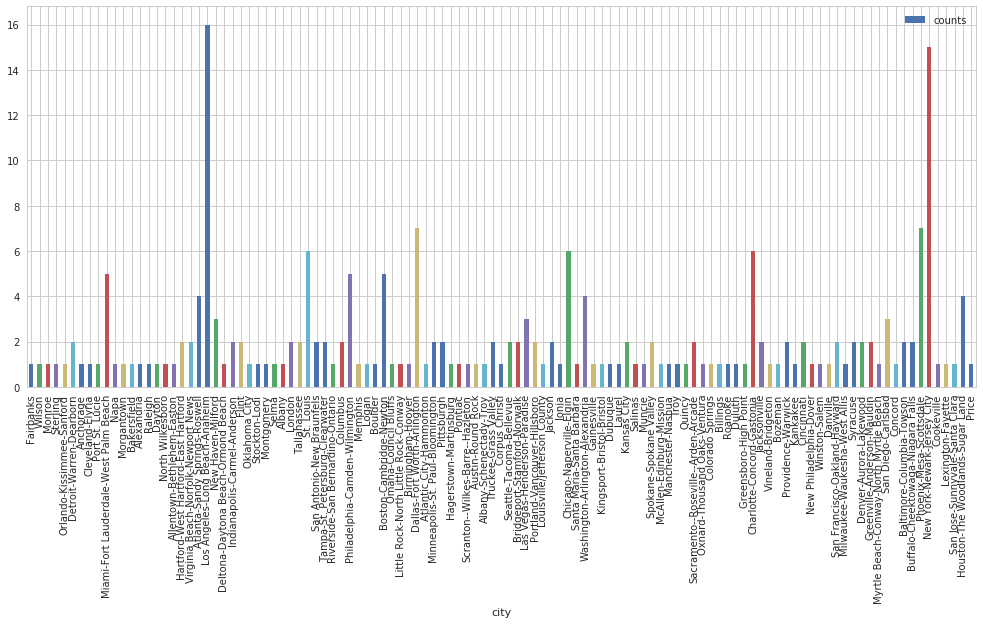

In [32]:
city_df  = events_df.groupby('city').agg(F.countDistinct('userId').alias('counts')).toPandas()
city_df.plot(x = 'city', y= 'counts', kind='bar',figsize=(17,7))

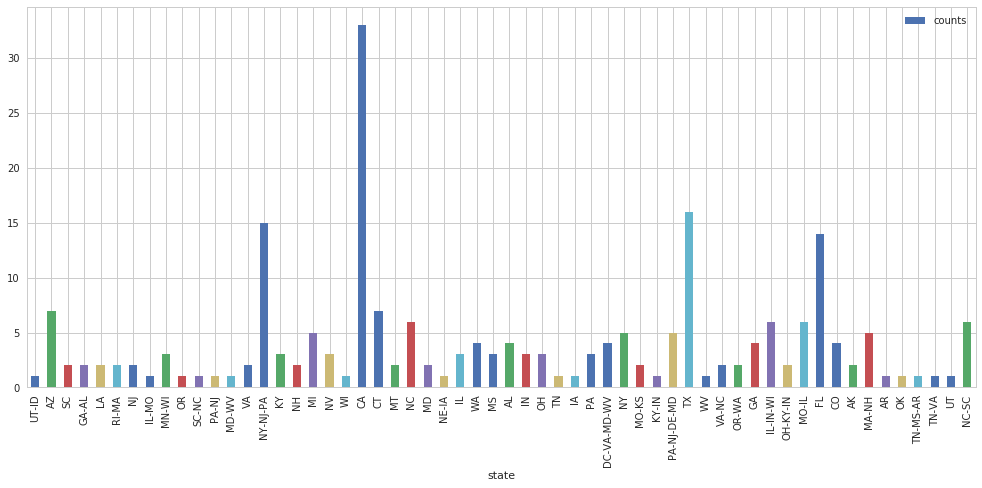

In [33]:
state_df  = events_df.groupby('state').agg(F.countDistinct('userId').alias('counts')).toPandas()
state_df.plot(x = 'state', y= 'counts', kind='bar',figsize=(17,7))

### page

In [34]:
events_df.groupby('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



### userAgent

In [35]:
events_df.select('userAgent').show()

+--------------------+
|           userAgent|
+--------------------+
|Mozilla/5.0 (Wind...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|Mozilla/5.0 (Wind...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (Wind...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Mac...|
|Mozilla/5.0 (Wind...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [36]:
events_df = events_df.withColumn("browser", F.when(events_df.userAgent.contains('Firefox'), "Firefox")
                                 .when(events_df.userAgent.contains('Chrome'), "Chrome")
                                 .when(events_df.userAgent.contains('Safari') ,"Safari")
                                 .when(events_df.userAgent.contains('Trident'), "Trident")
                                 .otherwise('Other')) 

In [37]:
events_df.groupby('browser').count().show()

+-------+------+
|browser| count|
+-------+------+
|Firefox| 55646|
| Safari| 61570|
|Trident| 15347|
| Chrome|145591|
+-------+------+



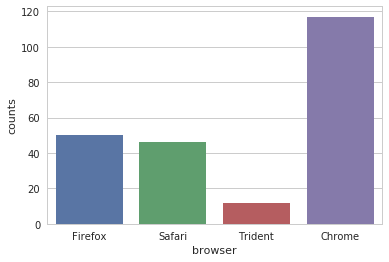

In [38]:
browser_df  = events_df.groupby('browser').agg(F.countDistinct('userId').alias('counts')).toPandas()
sns.barplot(x='browser',y='counts',data=browser_df)

In [39]:
events_df = events_df.withColumn("os", F.when(events_df.userAgent.contains('iPad'), "iPad")
                                 .when(events_df.userAgent.contains('Windows'), "Windows")
                                 .when(events_df.userAgent.contains('Macintosh') ,"Macintosh")
                                 .when(events_df.userAgent.contains('iPhone'), "iPhone")
                                 .when(events_df.userAgent.contains('Linux'), "Linux")
                                 .otherwise('Other')) 

In [40]:
events_df.groupby('os').count().show()

+---------+------+
|       os| count|
+---------+------+
|     iPad| 11381|
|   iPhone| 11192|
|Macintosh|102749|
|    Linux|  8961|
|  Windows|143871|
+---------+------+



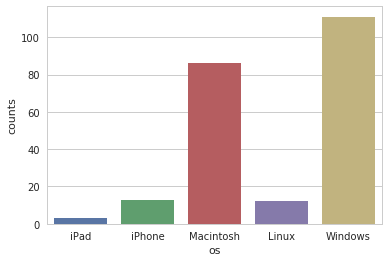

In [41]:
os_df  = events_df.groupby('os').agg(F.countDistinct('userId').alias('counts')).toPandas()
sns.barplot(x='os',y='counts',data=os_df)

### ts

We cant do much with the timestamp. So we will convert it to seasonality components like day of month, day of week etc

In [42]:
events_df = events_df.withColumn('ts_mod', F.col('ts')/1000)
events_df = events_df.withColumn('timestamp', F.from_unixtime('ts_mod').astype(T.TimestampType()) )

In [43]:
hour_convert = F.udf(lambda x: x.hour, T.IntegerType())
events_df = events_df.withColumn('day_of_month', F.dayofmonth(F.col('timestamp')))\
                     .withColumn('day_of_week', F.dayofweek('timestamp'))\
                     .withColumn("hour", F.hour("timestamp"))

In [44]:
events_df.select('timestamp', 'day_of_month', 'day_of_week', 'hour').toPandas().sample(10)

,timestamp,day_of_month,day_of_week,hour
168892,2018-11-20 02:03:16,20,3,2
5318,2018-10-02 21:39:04,2,3,21
193963,2018-11-27 00:31:33,27,3,0
197740,2018-11-27 22:08:19,27,3,22
151301,2018-11-14 19:01:52,14,4,19
224960,2018-10-13 16:15:37,13,7,16
101613,2018-10-31 07:37:21,31,4,7
82416,2018-10-25 11:27:58,25,5,11
258158,2018-10-26 16:10:59,26,6,16
258914,2018-10-27 17:35:02,27,7,17


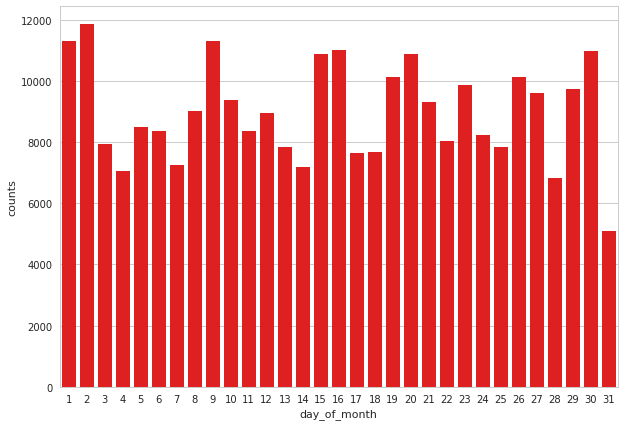

In [45]:
day_of_month  = events_df.groupby('day_of_month').agg(F.count('userId').alias('counts')).toPandas()
plt.figure(figsize = (10,7))
sns.barplot(x='day_of_month',y='counts',data=day_of_month, color = 'red')

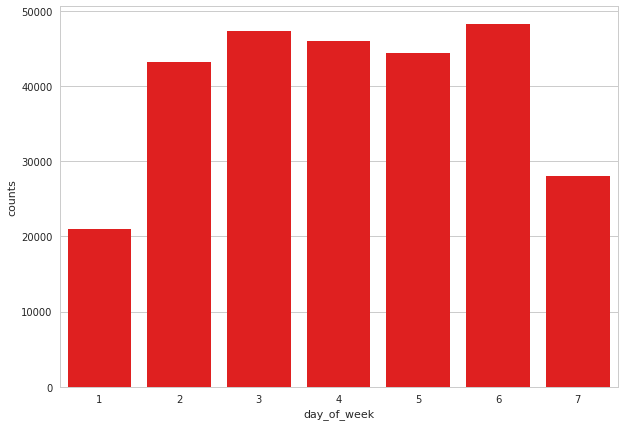

In [46]:
day_of_week  = events_df.groupby('day_of_week').agg(F.count('userId').alias('counts')).toPandas()
plt.figure(figsize = (10,7))
sns.barplot(x='day_of_week',y='counts',data=day_of_week, color = 'red')

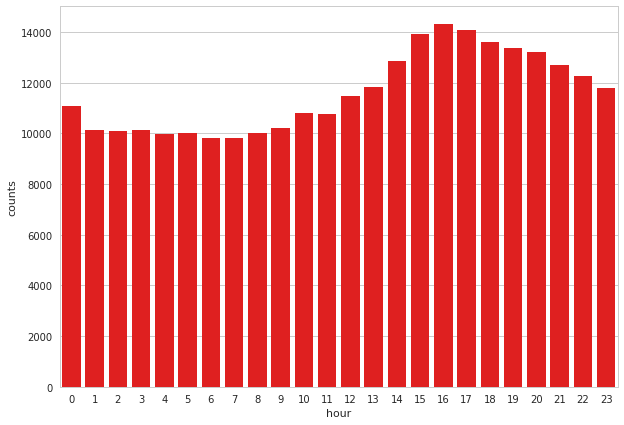

In [47]:
hour  = events_df.groupby('hour').agg(F.count('userId').alias('counts')).toPandas()
plt.figure(figsize = (10,7))
sns.barplot(x='hour',y='counts',data=hour, color = 'red')

It is very clear that activity patterns are seasonal across months, days and weeks. It is good that we have converted from epoch to seasonal parameters

## Churn

Churn is referred to the event when the user leaves the service/product. So in this dataset, we can use the column **page** to define our churn condition.

In [48]:
events_df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [49]:
events_df.where(F.col('page') == 'Cancellation Confirmation').count()

52

In [50]:
events_df.count()

278154

We can use the **page** = *Cancellation Confirmation* to define our churn event.

We can see there are just 52 instances of churning. The number seems much less compared to the total events. Let us validate if it causes any data imbalance issue later.

Now let us define the churn event.

In [51]:
events_df = events_df.withColumn('if_churn', F.when(F.col("page") == "Cancellation Confirmation", 1).otherwise(0))

In [52]:
events_df.groupby('if_churn').count().show()

+--------+------+
|if_churn| count|
+--------+------+
|       1|    52|
|       0|278102|
+--------+------+



In [53]:
if_user_churn = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
events_df = events_df.withColumn('churn',F.max('if_churn').over(if_user_churn))

In [54]:
events_df.groupby('churn').count().show()

+-----+------+
|churn| count|
+-----+------+
|    1| 44864|
|    0|233290|
+-----+------+



## Feature Exploration

## auth

In [55]:
events_df.groupby('auth','churn').agg(F.countDistinct('userId')).show()

+---------+-----+----------------------+
|     auth|churn|count(DISTINCT userId)|
+---------+-----+----------------------+
|Cancelled|    1|                    52|
|Logged In|    1|                    52|
|Logged In|    0|                   173|
+---------+-----+----------------------+



*auth* is just a state and it has no effect on churning

### gender

In [56]:
events_df.groupby('gender','churn').agg(F.countDistinct('userId')).show()

+------+-----+----------------------+
|gender|churn|count(DISTINCT userId)|
+------+-----+----------------------+
|     M|    1|                    32|
|     F|    0|                    84|
|     F|    1|                    20|
|     M|    0|                    89|
+------+-----+----------------------+



In [57]:
gender_churn_df = events_df.groupby('gender','churn').agg(F.countDistinct('userId').alias('count')).toPandas()

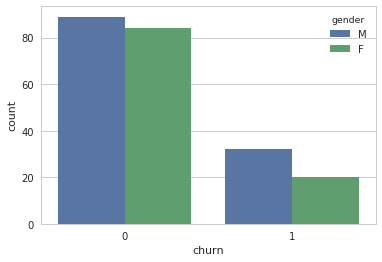

In [58]:
sns.barplot(x='churn', y='count', hue='gender', data=gender_churn_df)

**male_churn_ratio** = 32/121 = 0.264

**female_churn_ratio** = 20/104 = 0.192

Male churn ratio is slighty higher that female churn ratio. So it can be a good feature to explain churning.

### length

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82e3b416a0>]], dtype=object)

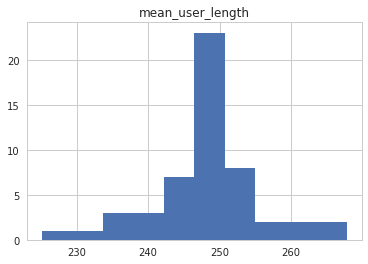

In [59]:
events_df.where(F.col('churn') == 1).groupby('userId').agg(F.mean('length').alias('mean_user_length'))\
.select('mean_user_length').toPandas().hist(bins = 10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82e51fb4a8>]], dtype=object)

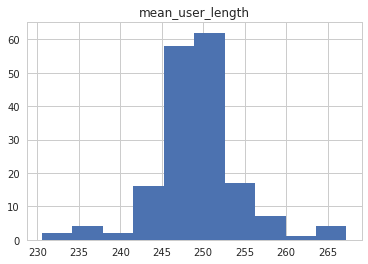

In [60]:
events_df.where(F.col('churn') == 0).groupby('userId').agg(F.mean('length').alias('mean_user_length'))\
.select('mean_user_length').toPandas().hist(bins = 10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82e5ffc160>]], dtype=object)

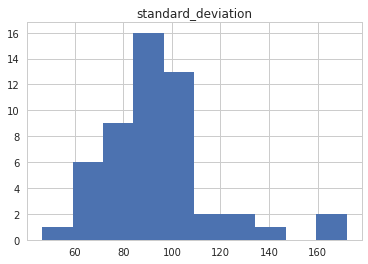

In [61]:
events_df.where(F.col('churn') == 1).groupby('userId').agg(F.stddev('length').alias('standard_deviation'))\
.select('standard_deviation').toPandas().hist(bins = 10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82e72c2128>]], dtype=object)

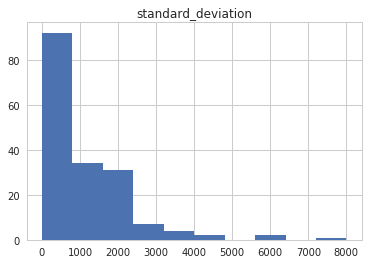

In [62]:
events_df.where(F.col('churn') == 0).groupby('userId').agg(F.count('length').alias('standard_deviation'))\
.select('standard_deviation').toPandas().hist(bins = 10)

Seems like the *length* parameter is a good feature to explain churning.

### level

In [63]:
events_df.groupby('churn','level').agg(F.countDistinct('userId')).show()

+-----+-----+----------------------+
|churn|level|count(DISTINCT userId)|
+-----+-----+----------------------+
|    0| free|                   149|
|    0| paid|                   129|
|    1| paid|                    36|
|    1| free|                    46|
+-----+-----+----------------------+



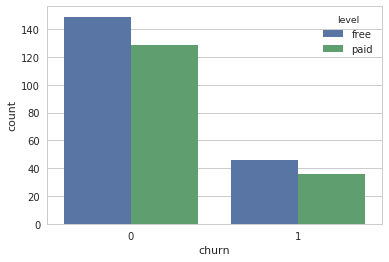

In [64]:
level_churn_df = events_df.groupby('churn','level').agg(F.countDistinct('userId').alias('count')).toPandas()
sns.barplot(x='churn', y='count', hue='level', data=level_churn_df)

**free_churn_ratio** =  46/(46+149) = 0.235

**paid_churn_ratio** =  36/(36+129) = 0.218

The ratio shows that there isnt much stronger correaltion between churn rations and level.

### location

In [65]:
events_df.groupby('churn','city').agg(F.countDistinct('userId')).show()

+-----+--------------------+----------------------+
|churn|                city|count(DISTINCT userId)|
+-----+--------------------+----------------------+
|    0|            Columbus|                     2|
|    1|              Monroe|                     1|
|    0|          Montgomery|                     1|
|    0|Hartford-West Har...|                     2|
|    0|   Manchester-Nashua|                     1|
|    0|Myrtle Beach-Conw...|                     1|
|    0|Chicago-Napervill...|                     5|
|    0|Miami-Fort Lauder...|                     3|
|    0|Charlotte-Concord...|                     6|
|    0|Buffalo-Cheektowa...|                     2|
|    1|              Quincy|                     1|
|    0|       Stockton-Lodi|                     1|
|    0|Milwaukee-Waukesh...|                     1|
|    0|            Danville|                     1|
|    1|         Kansas City|                     1|
|    0|              Dayton|                     1|
|    0|Atlan

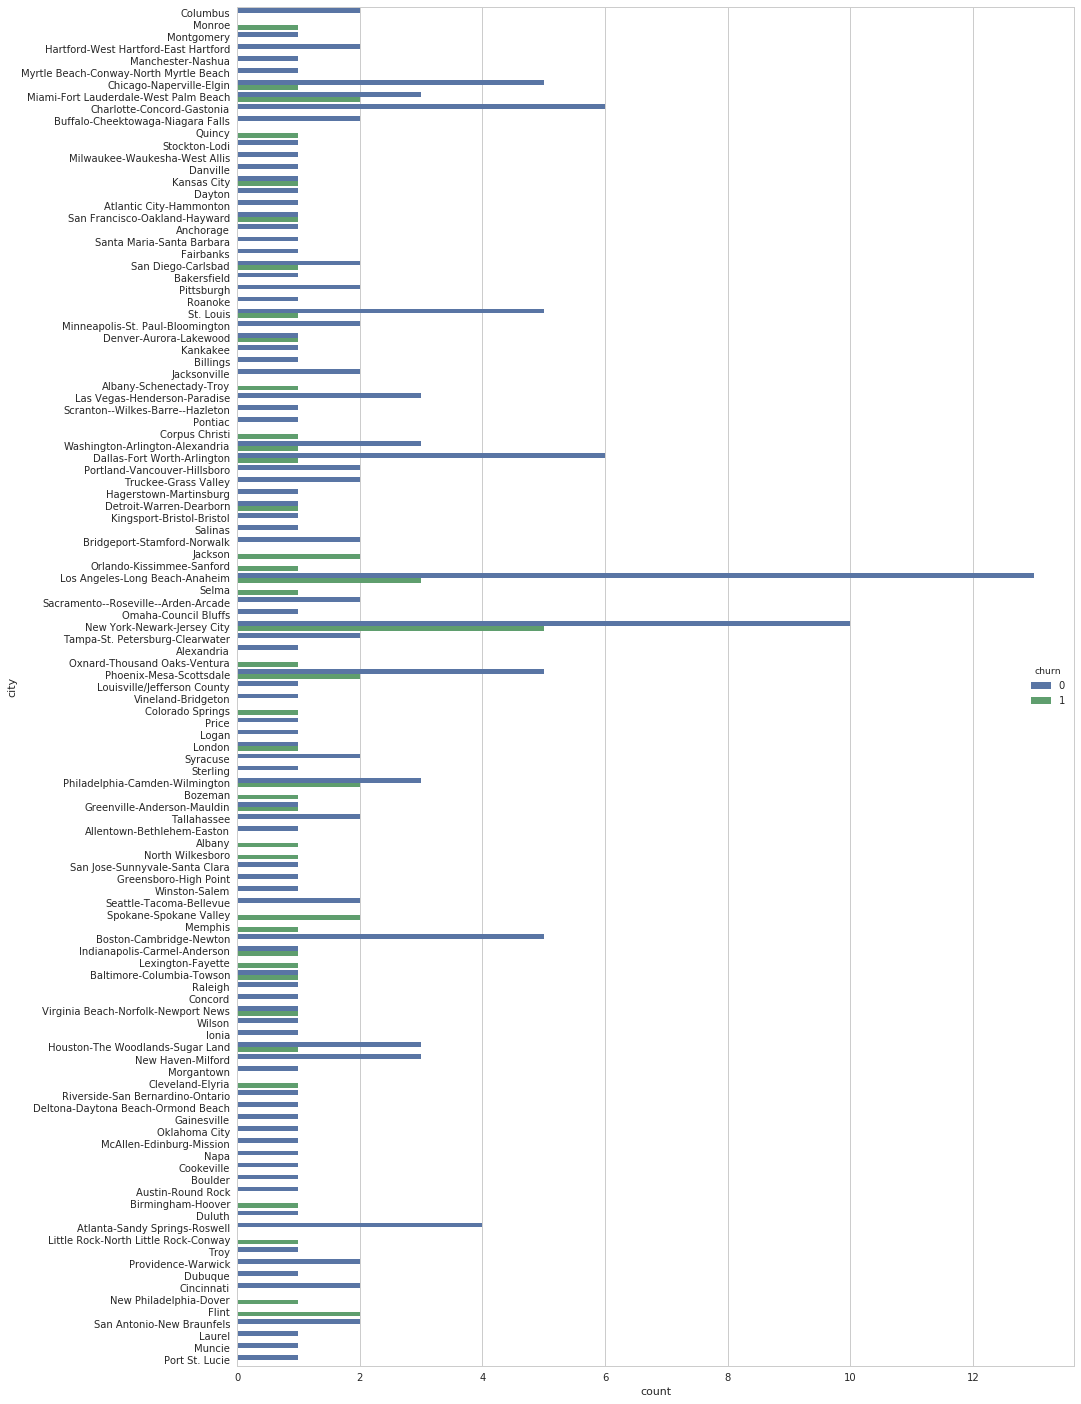

In [66]:
city_churn_df = events_df.groupby('churn','city').agg(F.countDistinct('userId').alias('count')).toPandas()
fig, ax = plt.subplots(figsize=(15,25))
sns.barplot(x='count', y='city', hue='churn', data=city_churn_df, ax=ax)

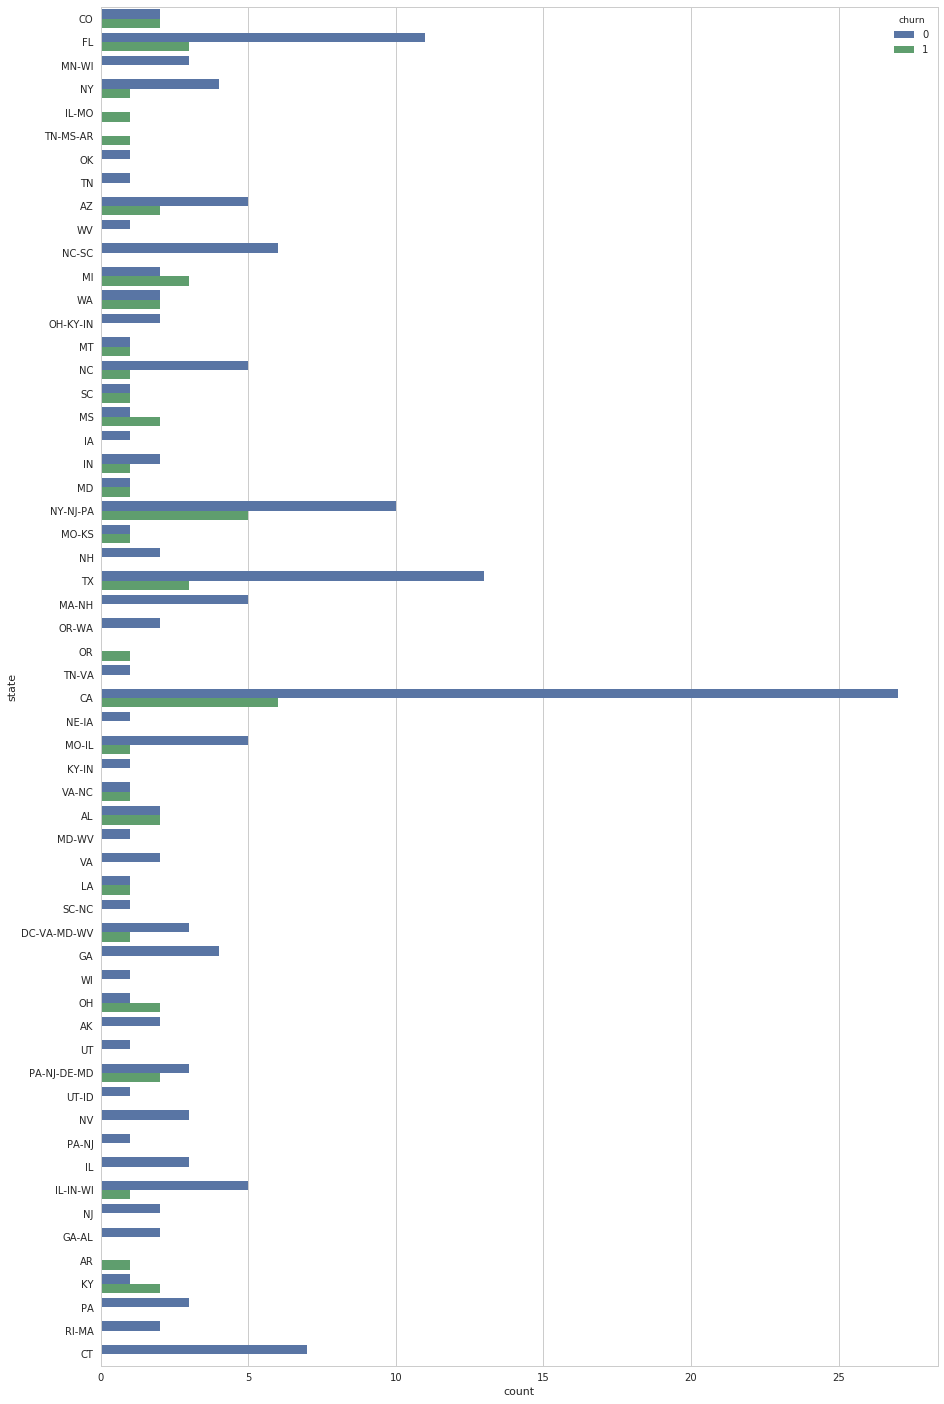

In [67]:
state_churn_df = events_df.groupby('churn','state').agg(F.countDistinct('userId').alias('count')).toPandas()
fig, ax = plt.subplots(figsize=(15,25))
sns.barplot(x='count', y='state', hue='churn', data=state_churn_df, ax=ax)

It seems location(state and city) doesn't provide stronger explainability for churning. The distributions of the churn ratios are nearly random.

### page

In [68]:
events_df.groupby('churn','page').agg(F.countDistinct('userId').alias('count')).show()

+-----+--------------------+-----+
|churn|                page|count|
+-----+--------------------+-----+
|    0|       Save Settings|  102|
|    1|              Logout|   46|
|    0|    Submit Downgrade|   40|
|    0|            NextSong|  173|
|    1|       Save Settings|   30|
|    0|          Add Friend|  162|
|    1|         Roll Advert|   50|
|    0|               Error|   95|
|    0|     Add to Playlist|  165|
|    0|               About|  124|
|    1|            Settings|   43|
|    1|      Submit Upgrade|   29|
|    0|           Thumbs Up|  170|
|    1|Cancellation Conf...|   52|
|    1|     Add to Playlist|   50|
|    1|            NextSong|   52|
|    1|                Home|   51|
|    1|             Upgrade|   37|
|    0|         Thumbs Down|  155|
|    1|    Submit Downgrade|    9|
+-----+--------------------+-----+
only showing top 20 rows



In [69]:
page_churn_df = events_df.groupby('churn','page').agg(F.countDistinct('userId').alias('count')).toPandas()

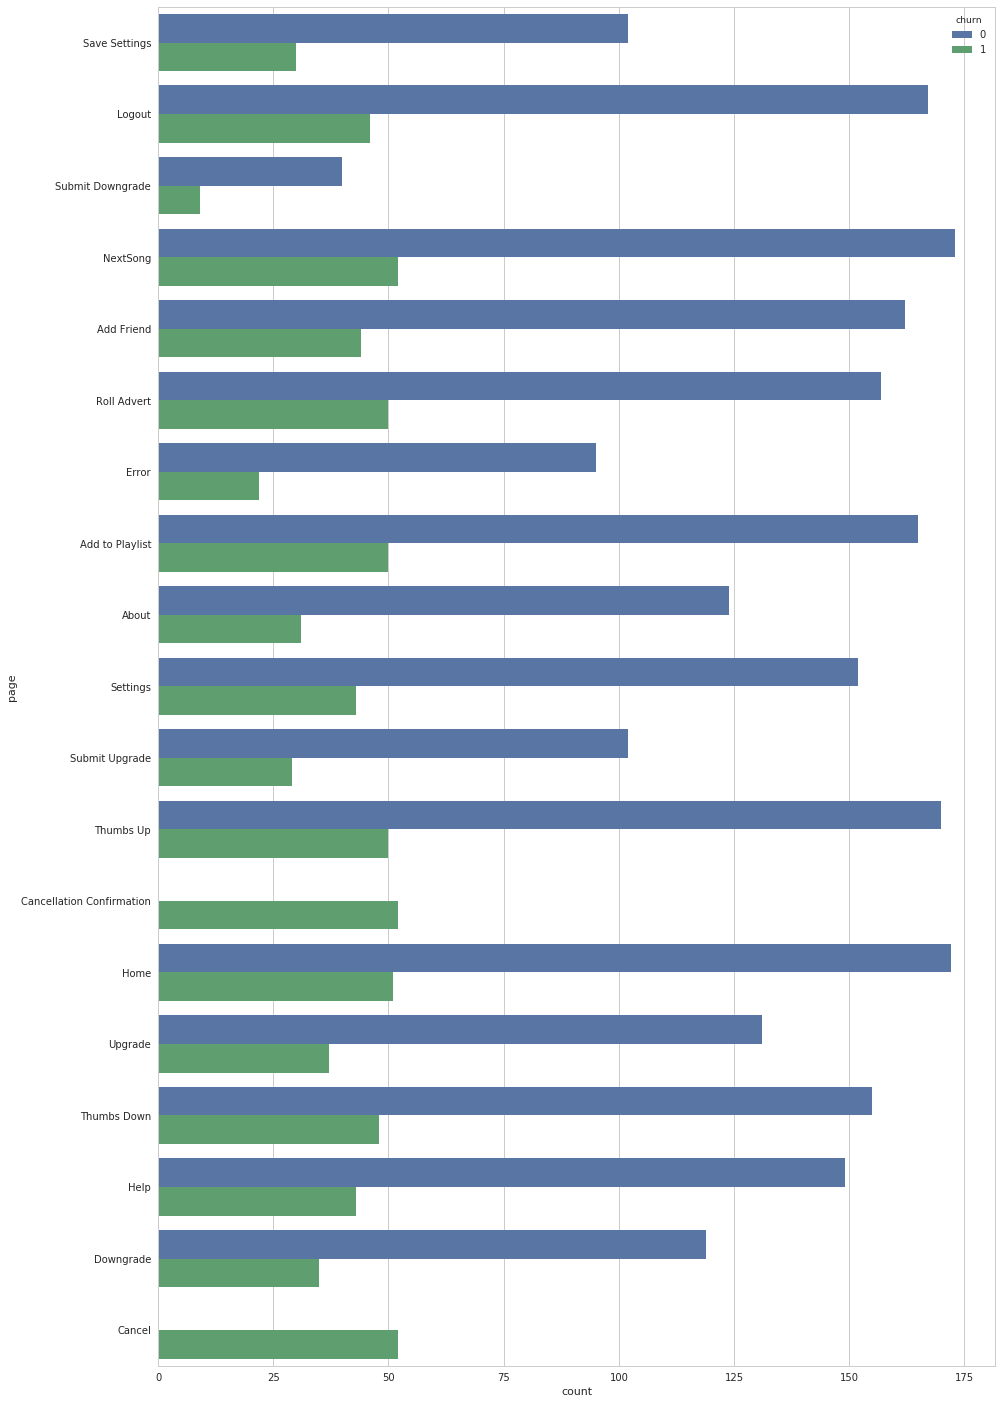

In [70]:
fig, ax = plt.subplots(figsize=(15,25))
sns.barplot(x='count', y='page', hue='churn', data=page_churn_df, ax=ax)

Clearly few events like *NextSong* have good correlation on churning events. The more the user engages in events like this, the lesser are the probability of churning

### userAgent

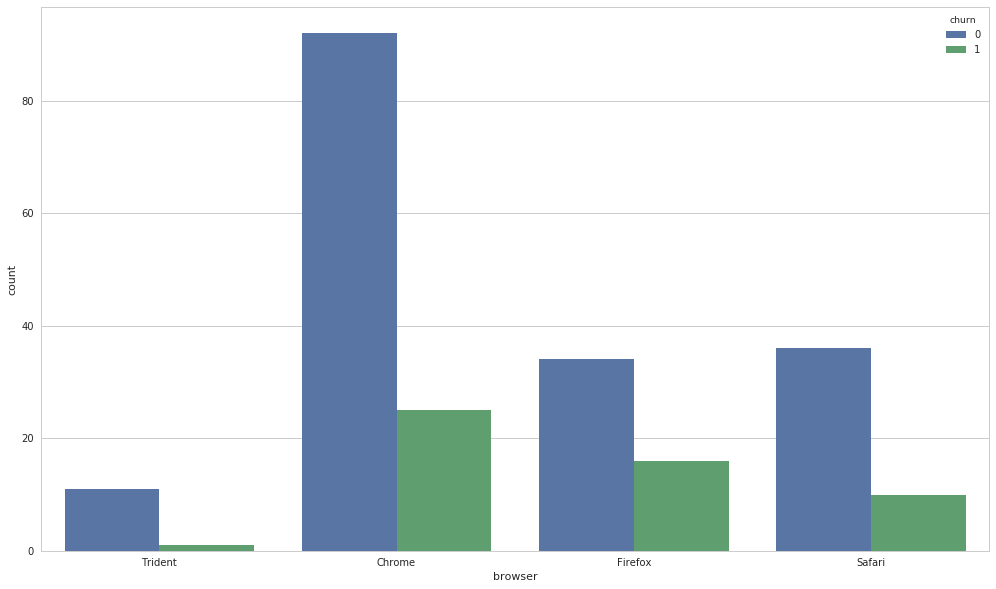

In [71]:
browser_churn_df = events_df.groupby('churn','browser').agg(F.countDistinct('userId').alias('count')).toPandas()
fig, ax = plt.subplots(figsize=(17,10))
sns.barplot(x='browser', y='count', hue='churn', data=browser_churn_df, ax=ax)

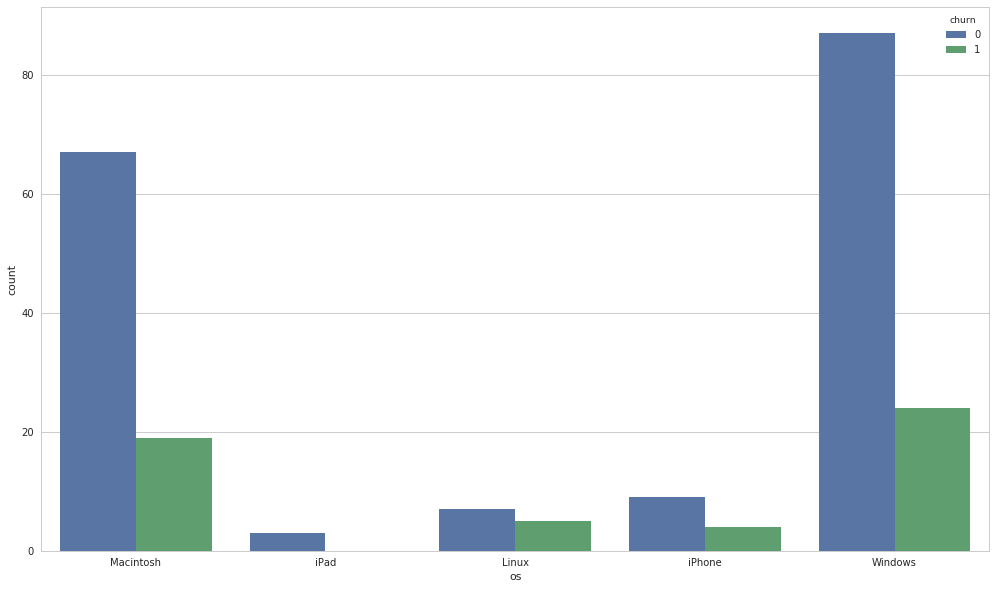

In [72]:
os_churn_df = events_df.groupby('churn','os').agg(F.countDistinct('userId').alias('count')).toPandas()
fig, ax = plt.subplots(figsize=(17,10))
sns.barplot(x='os', y='count', hue='churn', data=os_churn_df, ax=ax)

As you could see few platforms have higher churn ratio compared to others.

### ts

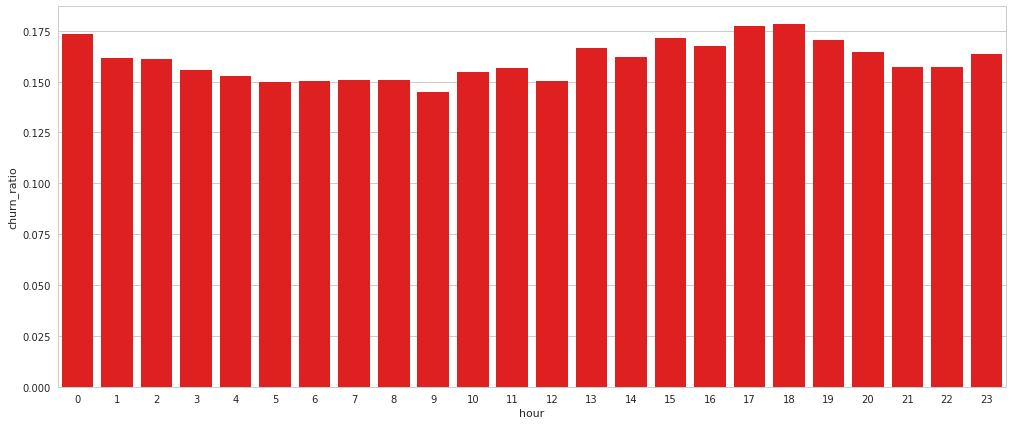

In [73]:
hour_churn_df = events_df.groupby('hour','churn').agg(F.count('userId').alias('count')).toPandas()
hour_churn_groupby = hour_churn_df.groupby(['churn','hour'])['count'].sum()/hour_churn_df.groupby('hour')['count'].sum()
churn_ratio_df = pd.DataFrame(hour_churn_groupby.loc[1]).reset_index()
churn_ratio_df.columns = ['hour', 'churn_ratio']
fig, ax = plt.subplots(figsize=(17,7))
sns.barplot(x='hour', y='churn_ratio', data=churn_ratio_df, ax=ax, color = 'red')

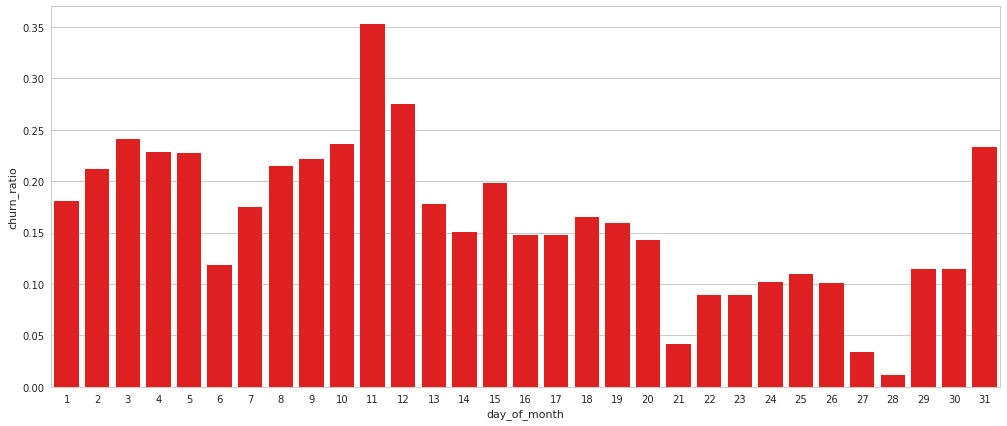

In [74]:
day_of_month_churn_df = events_df.groupby('day_of_month','churn').agg(F.count('userId').alias('count')).toPandas()
day_of_month_churn_groupby = day_of_month_churn_df.groupby(['churn','day_of_month'])['count'].sum()/day_of_month_churn_df.groupby('day_of_month')['count'].sum()
churn_ratio_df = pd.DataFrame(day_of_month_churn_groupby.loc[1]).reset_index()
churn_ratio_df.columns = ['day_of_month', 'churn_ratio']
fig, ax = plt.subplots(figsize=(17,7))
sns.barplot(x='day_of_month', y='churn_ratio', data=churn_ratio_df, ax=ax, color = 'red')

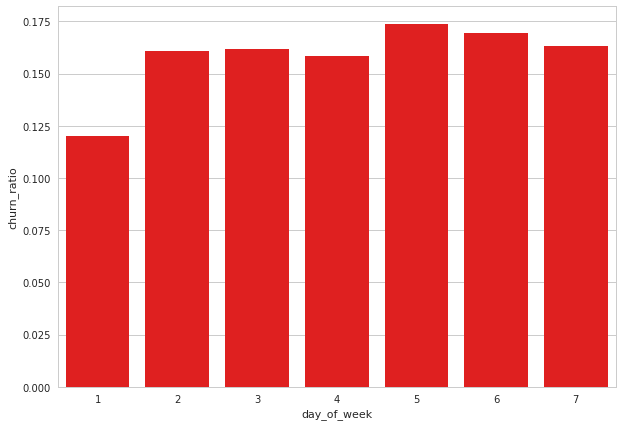

In [75]:
day_of_week_churn_df = events_df.groupby('day_of_week','churn').agg(F.count('userId').alias('count')).toPandas()
day_of_week_churn_groupby = day_of_week_churn_df.groupby(['churn','day_of_week'])['count'].sum()/day_of_week_churn_df.groupby('day_of_week')['count'].sum()
churn_ratio_df = pd.DataFrame(day_of_week_churn_groupby.loc[1]).reset_index()
churn_ratio_df.columns = ['day_of_week', 'churn_ratio']
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(x='day_of_week', y='churn_ratio', data=churn_ratio_df, ax=ax, color = 'red')

The churn ratio follows a seasonality pattern. Clearly it can be a good feature for churning.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Creating Features DF

In [76]:
feature_dict = {}

### Categorical Features

Gender of the user will be a categorical feature

In [77]:
user_gender_df = events_df.groupby('userId').agg(F.first('gender').alias('gender'))
feature_dict['user_gender_df'] = user_gender_df

An user can be free user or paid user. Also, there can be users who would be free user at some point and will also have subscribed to the service for some time period. Even those users can also be considered as paid users. Since **F.max()** will pick the *paid* in case an user has been both a paid and a free user, we will use that function to build the feature

In [78]:
events_df.select(F.max('level')).show()

+----------+
|max(level)|
+----------+
|      paid|
+----------+



In [79]:
user_level_df = events_df.groupby('userId').agg(F.max('level').alias('level'))
feature_dict['user_level_df'] = user_level_df

In [80]:
user_level_df.show()

+------+-----+
|userId|level|
+------+-----+
|100010| free|
|200002| paid|
|   125| free|
|   124| paid|
|    51| paid|
|     7| free|
|    15| paid|
|    54| paid|
|   155| paid|
|100014| paid|
|   132| paid|
|   154| free|
|   101| paid|
|    11| paid|
|   138| paid|
|300017| paid|
|100021| free|
|    29| paid|
|    69| paid|
|   112| free|
+------+-----+
only showing top 20 rows



We can also add the broswer and os, as a feature. Incidentally, in the dataset, an user had belonged to only one platform and not multiple. Thus we will use **F.first()** to capture that information.

In [81]:
user_browser_df = events_df.groupby('userId').agg(F.first('browser').alias('browser'))
feature_dict['user_browser_df'] = user_browser_df

In [82]:
user_browser_df.show()

+------+-------+
|userId|browser|
+------+-------+
|100010| Safari|
|200002| Safari|
|   125| Chrome|
|   124| Chrome|
|    51| Chrome|
|     7|Firefox|
|    15| Chrome|
|    54|Firefox|
|   155| Chrome|
|100014| Chrome|
|   132| Safari|
|   154| Chrome|
|   101|Firefox|
|    11|Trident|
|   138| Safari|
|300017| Safari|
|100021| Safari|
|    29| Safari|
|    69| Chrome|
|   112|Firefox|
+------+-------+
only showing top 20 rows



In [83]:
user_os_df = events_df.groupby('userId').agg(F.first('os').alias('os'))
feature_dict['user_os_df'] = user_os_df

In [84]:
user_os_df.show()

+------+---------+
|userId|       os|
+------+---------+
|100010|   iPhone|
|200002|   iPhone|
|   125|Macintosh|
|   124|Macintosh|
|    51|  Windows|
|     7|  Windows|
|    15|  Windows|
|    54|  Windows|
|   155|  Windows|
|100014|  Windows|
|   132|Macintosh|
|   154|  Windows|
|   101|  Windows|
|    11|  Windows|
|   138|     iPad|
|300017|Macintosh|
|100021|Macintosh|
|    29|Macintosh|
|    69|  Windows|
|   112|  Windows|
+------+---------+
only showing top 20 rows



As we saw that the seasonal features also plays a role on the churning, we will capture that information as well. Here we will record the time interval where the user has spent the most time.

In [85]:
user_season_df = events_df.groupby('userId').agg(F.mean('hour').astype(T.IntegerType()).alias('hour'),\
                                                 F.mean('day_of_week').astype(T.IntegerType()).alias('day_of_week'),\
                                                 F.mean('day_of_month').astype(T.IntegerType()).alias('day_of_month'))
feature_dict['user_season_df'] = user_season_df

In [86]:
user_season_df.show()

+------+----+-----------+------------+
|userId|hour|day_of_week|day_of_month|
+------+----+-----------+------------+
|100010|  11|          4|          12|
|200002|  15|          4|          16|
|   125|   4|          6|          12|
|    51|  11|          3|           8|
|   124|  12|          3|          14|
|     7|   9|          4|          18|
|    54|  12|          4|          11|
|    15|  12|          4|          11|
|   155|   9|          4|          16|
|   132|  13|          3|          11|
|   154|  17|          5|          12|
|100014|  15|          4|          16|
|   101|  11|          3|           8|
|    11|  13|          3|          16|
|   138|  11|          4|          25|
|300017|  13|          4|          12|
|    29|  12|          3|          14|
|    69|  12|          4|          17|
|100021|   6|          3|          18|
|    42|  12|          3|          14|
+------+----+-----------+------------+
only showing top 20 rows



### Numerical features

Since length was an important feature, we will pick the minimum, maximum, mean and standard deviation of length for each user.

In [87]:
user_length_df = events_df.groupby('userId').agg(F.min('length').alias('min_length'), F.max('length').alias('max_length'), \
                                F.mean('length').alias('mean_length'), F.stddev('length').alias('stddev_length'))
feature_dict['user_length_df'] = user_length_df

In [88]:
user_length_df.show(5)

+------+----------+----------+------------------+------------------+
|userId|min_length|max_length|       mean_length|     stddev_length|
+------+----------+----------+------------------+------------------+
|100010|  52.27057| 538.85342|  243.421444909091|  79.5156544698794|
|200002|  26.56608| 592.06485|242.91699209302305|   75.447490312729|
|   125| 178.41587| 391.26159|261.13913750000006|  78.1110647194169|
|    51|   4.04853|2594.87302|247.88055082899118|104.57060972073867|
|   124|  18.05016|2369.04444|248.17653659965674| 99.33044264553511|
+------+----------+----------+------------------+------------------+
only showing top 5 rows



Since the engagement information like NextSong, Add to Playlist will give an idea about the activity volume of the user in the platform, it can be a good feature to describe churning. So we will counts of specific page types for different users.

In [89]:
user_page_df = events_df.where(F.col('page').isin('NextSong','Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Roll Advert'))\
                                                    .groupBy('userId').pivot('page').count().fillna(0)
feature_dict['user_page_df'] = user_page_df

In [90]:
user_page_df.show()

+------+----------+---------------+--------+-----------+-----------+---------+
|userId|Add Friend|Add to Playlist|NextSong|Roll Advert|Thumbs Down|Thumbs Up|
+------+----------+---------------+--------+-----------+-----------+---------+
|100010|         4|              7|     275|         52|          5|       17|
|200002|         4|              8|     387|          7|          6|       21|
|   125|         0|              0|       8|          1|          0|        0|
|     7|         1|              5|     150|         16|          1|        7|
|   124|        74|            118|    4079|          4|         41|      171|
|    51|        28|             52|    2111|          0|         21|      100|
|    54|        33|             72|    2841|         47|         29|      163|
|    15|        31|             59|    1914|          1|         14|       81|
|   155|        11|             24|     820|          8|          3|       58|
|   132|        41|             38|    1928|        

User engagement can also be defined by the number of unique songs streamed by the user, total number of songs streamed on all a whole by the user and the unique number of artists that the user had listened to. So we will capture this information as features as well

In [91]:
user_songs_df = events_df.groupby('userId').agg(F.countDistinct('song').alias('total_unique_stream'), \
                                               F.count('song').alias('total_stream'))
feature_dict['user_songs_df'] = user_songs_df

In [92]:
user_songs_df.show()

+------+-------------------+------------+
|userId|total_unique_stream|total_stream|
+------+-------------------+------------+
|100010|                269|         275|
|200002|                378|         387|
|   125|                  8|           8|
|    51|               1854|        2111|
|   124|               3339|        4079|
|     7|                148|         150|
|    15|               1707|        1914|
|    54|               2414|        2841|
|   155|                759|         820|
|   132|               1718|        1928|
|100014|                248|         257|
|   154|                 83|          84|
|   101|               1608|        1797|
|    11|                616|         647|
|   138|               1791|        2070|
|300017|               3013|        3632|
|    29|               2562|        3028|
|    69|               1036|        1125|
|100021|                226|         230|
|   112|                211|         215|
+------+-------------------+------

In [93]:
user_artist_df = events_df.groupby('userId').agg(F.countDistinct('artist').alias('total_unique_artists'))
feature_dict['user_artist_df'] = user_artist_df

In [94]:
user_artist_df.show()

+------+--------------------+
|userId|total_unique_artists|
+------+--------------------+
|100010|                 252|
|200002|                 339|
|   125|                   8|
|    51|                1385|
|   124|                2232|
|     7|                 142|
|    15|                1302|
|    54|                1744|
|   155|                 643|
|   132|                1299|
|   154|                  78|
|100014|                 233|
|   101|                1241|
|    11|                 534|
|   138|                1332|
|300017|                2070|
|    29|                1804|
|    69|                 865|
|100021|                 207|
|    42|                2073|
+------+--------------------+
only showing top 20 rows



### Putting it all together

In [95]:
final_df = None

for df_key in feature_dict.keys():
    if final_df is None:
        final_df = feature_dict[df_key]
    else:
        final_df = final_df.join(feature_dict[df_key], on = 'userId', how = 'inner')

In [96]:
user_churn_state = events_df.groupby('userId').agg(F.first('churn').alias('label'))

In [97]:
final_df = final_df.join(user_churn_state, on = 'userId', how = 'inner')

In [98]:
final_df = final_df.drop("userId")

In [99]:
final_df.cache()

DataFrame[gender: string, level: string, browser: string, os: string, hour: int, day_of_week: int, day_of_month: int, min_length: double, max_length: double, mean_length: double, stddev_length: double, Add Friend: bigint, Add to Playlist: bigint, NextSong: bigint, Roll Advert: bigint, Thumbs Down: bigint, Thumbs Up: bigint, total_unique_stream: bigint, total_stream: bigint, total_unique_artists: bigint, label: int]

In [100]:
final_df.toPandas().head()

,gender,level,browser,os,hour,day_of_week,day_of_month,min_length,max_length,mean_length,...,Add Friend,Add to Playlist,NextSong,Roll Advert,Thumbs Down,Thumbs Up,total_unique_stream,total_stream,total_unique_artists,label
0,F,free,Safari,iPhone,11,4,12,52.27057,538.85342,243.421445,...,4,7,275,52,5,17,269,275,252,0
1,M,paid,Safari,iPhone,15,4,16,26.56608,592.06485,242.916992,...,4,8,387,7,6,21,378,387,339,0
2,M,free,Chrome,Macintosh,4,6,12,178.41587,391.26159,261.139138,...,0,0,8,1,0,0,8,8,8,1
3,F,paid,Chrome,Macintosh,12,3,14,18.05016,2369.04444,248.176537,...,74,118,4079,4,41,171,3339,4079,2232,0
4,M,paid,Chrome,Windows,11,3,8,4.04853,2594.87302,247.880551,...,28,52,2111,0,21,100,1854,2111,1385,1


In [101]:
final_df.toPandas().iloc[0]

gender                        F
level                      free
browser                  Safari
os                       iPhone
hour                         11
day_of_week                   4
day_of_month                 12
min_length              52.2706
max_length              538.853
mean_length             243.421
stddev_length           79.5157
Add Friend                    4
Add to Playlist               7
NextSong                    275
Roll Advert                  52
Thumbs Down                   5
Thumbs Up                    17
total_unique_stream         269
total_stream                275
total_unique_artists        252
label                         0
Name: 0, dtype: object

In [102]:
final_df.count()

225

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Train Test Split

Since we will be using 

In [103]:
categorical_columns = ['gender', 'level', 'browser', 'os', 'hour', 'day_of_week', 'day_of_month']
numerical_columns = ['min_length', 'max_length', 'mean_length', 'stddev_length', 'Add Friend', 'Add to Playlist', \
                     'NextSong', 'Roll Advert', 'Thumbs Down', 'Thumbs Up', 'total_unique_stream', 'total_stream', 'total_unique_artists']

In [104]:
categorical_index = [i+"_index" for i in categorical_columns]
categorical_encoded = [i+"_encoded" for i in categorical_columns]

In [105]:
stages = []
for col in categorical_columns:
    string_indexer = StringIndexer(inputCol= col, outputCol= col + "_index")
    stages += [string_indexer]

In [106]:
one_hot_encoding = OneHotEncoderEstimator(inputCols = categorical_index, outputCols = categorical_encoded)
stages += [one_hot_encoding]

In [107]:
vector_assember = VectorAssembler(inputCols=numerical_columns, outputCol='numerical_features')
scaler = StandardScaler(withMean=True, withStd=True, inputCol='numerical_features', outputCol='numerical_features_scaled')
stages += [vector_assember, scaler]

# label_string_indexer = StringIndexer(inputCol="churn", outputCol="label")
# stages += [label_string_indexer]

In [108]:
final_vector_assember = VectorAssembler(inputCols=categorical_index + ['numerical_features_scaled'], outputCol='features')
stages += [final_vector_assember]

In [109]:
processed_final_df = Pipeline(stages = stages).fit(final_df).transform(final_df)

In [115]:
processed_final_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [110]:
# minority_size = processed_final_df.where(F.col('label') == '1').count()
# processed_df_1 = processed_final_df.where(F.col('label') == '1')
# processed_df_0 = processed_final_df.where(F.col('label') == '0').sample(1.0, seed=7).limit(minority_size)
# processed_final_df_balanced = processed_df_1.union(processed_df_0)
# processed_final_df_balanced = processed_final_df_balanced.orderBy(F.rand())

In [111]:
train_df, test_df = processed_final_df.randomSplit([0.75, 0.25], seed=7)

In [112]:
train_df.count()

170

In [113]:
test_df.count()

55

Here we will be using three different algorithms for training.

* **1. Logistic Regression**
* **2. Random Forest Regressor**
* **3. Support Vector Machine**

In [114]:
import time
evaluator = MulticlassClassificationEvaluator()

### Logistic Regression

In [247]:
tic = time.time()

lr = LogisticRegression(maxIter=10)
lr_model = lr.fit(train_df)

toc = time.time()
print('Computational time for Logisitic Regression', round(toc-tic,2))

Computational time for Logisitic Regression 33.29


In [248]:
train_pred = lr_model.transform(train_df)
print('Train Accuracy- ', evaluator.evaluate(train_pred.select('label','prediction'), {evaluator.metricName: "accuracy"}))
print('Train F1 Score- ', evaluator.evaluate(train_pred.select('label','prediction'), {evaluator.metricName: "f1"}))

Train Accuracy-  0.8
Train F1 Score-  0.735


In [249]:
test_pred = lr_model.transform(test_df)
print('Test Accuracy- ', evaluator.evaluate(test_pred.select('label','prediction'), {evaluator.metricName: "accuracy"}))
print('Test F1 Score- ', evaluator.evaluate(test_pred.select('label','prediction'), {evaluator.metricName: "f1"}))

Test Accuracy-  0.6545454545454545
Test F1 Score-  0.5728488739724694


### Random Forest Classifier

In [250]:
tic = time.time()

rf = RandomForestClassifier()
rf_model = rf.fit(train_df)
toc = time.time()

print('Computational time for Random Forest Classifier', round(toc-tic,2))

Computational time for Random Forest Classifier 47.83


In [251]:
train_pred = rf_model.transform(train_df)
print('Train Accuracy- ', evaluator.evaluate(train_pred.select('label','prediction'), {evaluator.metricName: "accuracy"}))
print('Train F1 Score- ', evaluator.evaluate(train_pred.select('label','prediction'), {evaluator.metricName: "f1"}))

Train Accuracy-  0.9176470588235294
Train F1 Score-  0.9093827671913837


In [252]:
test_pred = rf_model.transform(test_df)
print('Test Accuracy- ', evaluator.evaluate(test_pred.select('label','prediction'), {evaluator.metricName: "accuracy"}))
print('Test F1 Score- ', evaluator.evaluate(test_pred.select('label','prediction'), {evaluator.metricName: "f1"}))

Test Accuracy-  0.7090909090909091
Test F1 Score-  0.62989898989899


### Support Vector Machine

In [253]:
tic = time.time()

svm = LinearSVC(maxIter=10, regParam=0.1)
svm_model = svm.fit(train_df)

toc = time.time()

print('Computational time for SVM', round(toc-tic,2))

Computational time for SVM 149.36


In [254]:
train_pred = svm_model.transform(train_df)
print('Train Accuracy- ', evaluator.evaluate(train_pred.select('label','prediction'), {evaluator.metricName: "accuracy"}))
print('Train F1 Score- ', evaluator.evaluate(train_pred.select('label','prediction'), {evaluator.metricName: "f1"}))

Train Accuracy-  0.7941176470588235
Train F1 Score-  0.7029893924783028


In [265]:
test_pred = svm_model.transform(test_df)
print('Test Accuracy- ', evaluator.evaluate(test_pred.select('label','prediction'), {evaluator.metricName: "accuracy"}))
print('Test F1 Score- ', evaluator.evaluate(test_pred.select('label','prediction'), {evaluator.metricName: "f1"}))

Test Accuracy-  0.6909090909090909
Test F1 Score-  0.564613880742913


From above results we find that Random Forest Classifier categorizes the data well. Lets g a bit deeper on this algorithm and tune the hyperparameters.

### Hyperparameter tuning for Random Forest Classifier

In [116]:
tic = time.time()
rf = RandomForestClassifier()


paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20,75]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3) 


cv_model = crossval.fit(train_df)
toc = time.time()
print('Computational time for tuning Random Forest Classifier', round(toc-tic,2))


train_pred = cv_model.transform(train_df)
print('Train Accuracy- ', evaluator.evaluate(train_pred.select('label','prediction'), {evaluator.metricName: "accuracy"}))
print('Train F1 Score- ', evaluator.evaluate(train_pred.select('label','prediction'), {evaluator.metricName: "f1"}))

test_pred = cv_model.transform(test_df)
print('Test Accuracy- ', evaluator.evaluate(test_pred.select('label','prediction'), {evaluator.metricName: "accuracy"}))
print('Test F1 Score- ', evaluator.evaluate(test_pred.select('label','prediction'), {evaluator.metricName: "f1"}))

Computational time for tuning Random Forest Classifier 1004.02
Train Accuracy-  0.9941176470588236
Train F1 Score-  0.99408587436258
Test Accuracy-  0.7454545454545455
Test F1 Score-  0.7072233967582805


In [160]:
cv_model.bestModel.getNumTrees

75

In [162]:
cv_model.avgMetrics

[0.6857132426465493,
 0.6857132426465493,
 0.6796678371376585,
 0.6796678371376585]

# Room for improvement

We could still improve the performance using a bigger dataset, more candidate hyper-parameters for tuning, sophisticated techniques to counteract class imbalance like SMOTE etc. 
Due to lack of computing power, we were not possible to work on these.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.